<a href="https://colab.research.google.com/github/jinjukang67/AIFFEL_Project/blob/master/GD_4_news_category_multiclass_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트: Vocabulary Size를 변경해서 시도해보기

> 단어의 수에 따라서 모델의 성능이 어떻게 변하는지 테스트해보자!



In [ ]:
import tensorflow
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt

print(tensorflow.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)

2.8.0
3.2.2
0.11.2
1.21.5
1.3.5
1.0.2


# 1. 모든 단어 사용

In [ ]:
# 텐서프로우 데이터셋에서 가져온다.
# 이때 num_words는 데이터 빈도수 기준 상위 몇 번째 단어까지 사용할 건가 말함
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [ ]:
# 단어집합 가져오기
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = { index+3 : word for word, index in word_index.items() }

# index_to_word 앞에도 pad, sos, unk 토큰 넣어주자
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

# train 텍스트 데이터로 변환하기
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [ ]:
# test 텍스트 데이터로 변환하기
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


### 1.1 벡터화하기
- Bag of Words 기반

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print("DTM의 크기: ",x_train_dtm.shape)

# TF-IDF Matrix 생성
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print("TF-IDF Matrix의 크기: ",tfidfv.shape)

DTM의 크기:  (8982, 26506)
TF-IDF Matrix의 크기:  (8982, 26506)


> 단어는 총 26,506개

### 1.2 나이브 베이즈 분류기

In [ ]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

In [ ]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [ ]:
# test 데이터도 DTM -> tf-idf 행렬로 변환
x_test_dtm = dtmvector.transform(x_test)
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

predicted = model.predict(tfidfv_test)

# 카테고리 라벨 분류한 정확도
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.5997328584149599


In [ ]:
x_test[3]

'<sos> graham mccormick oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the oak hill and north rucias fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to prepay principal on its senior secured notes semi annual principal payments on the remaining 40 mln dlrs of notes have been satisfied until december 1988 as a result it said the company said the note agreements were amended to reflect an easing of some financial covenants and an increase of interest to 13 5 pct from 13 0 pct until december 1990 it said the noteholders exercise price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the oak hill field reuter 3'

In [ ]:
y_test[3]

4

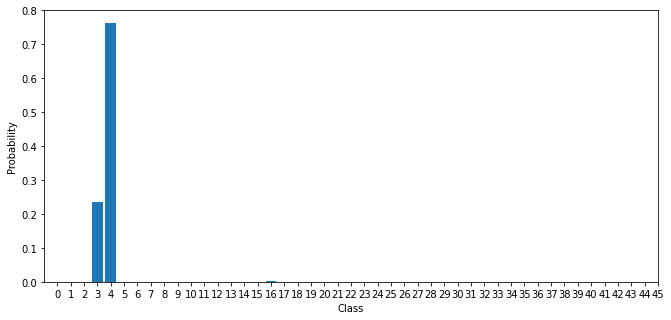

In [ ]:
probability_3 = model.predict_proba(tfidfv_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(model.classes_, probability_3)
plt.xlim(-1, 21)
plt.xticks(model.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

- 거의 80프로의 확률로 인덱스 3번 뉴스기사가 4번 클래스라고 맞게 예측했다.

**F1-Score, Confusion Matrix**
- macro: 단순평균
- weighted: 각 클래스에 속하는 표본의 개수로 가중평균
- accuracy: 정확도. 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.18      0.29        99
          17       0.00    

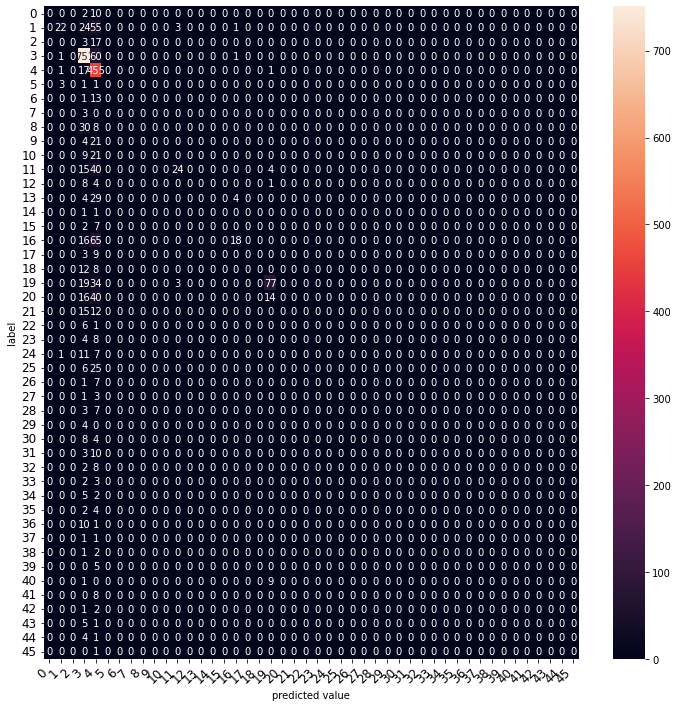

In [ ]:
# confusion matrix 시각화
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(12,12))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

graph_confusion_matrix(model, tfidfv_test, y_test)

###1.3 Complement Naive Bayes Classifier(CNB)

- 데이터가 불균형할 경우를 대비해 나이브 베이즈 분류기를 보완한 것

In [ ]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [ ]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7649154051647373


-> 나이브 베이즈 분류기보다 약 15프로나 더 높은 성능을 냄

### 1.4 로지스틱 회귀(Logistic Regression)
- 다중 클래스 분류
- C argument
    - 
A high value of C tells the model to give high weight to the training data, and a lower weight to the complexity penalty. Thus, a high Hyper Parameter value C indicates that training data is more important and reflects the real world data, whereas low value is just the opposite of this.
    > C: float, default=1.0 Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.



In [ ]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=10000)

In [ ]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.813446126447017


### 1.5 선형 서포트 벡터 머신(Linear Support Vector Machine)
- 선형 분류
- 대부분 이진 분류 모델
- `LinearSVC`는 이진 분류를 위한 모델
- 이번 실습에서 위 모델을 사용하면 클래스의 수만큼 이진 분류 모델이 만들어진다.

In [ ]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [ ]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7729296527159395


### 1.6 결정 트리(Decision Tree)
- 분류나 회귀 문제에 사용되는 모델

In [ ]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [ ]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6211041852181657


- 결정트리의 정확도가 62%로 가장 낮음

### 1.7 랜덤 포레스트(Random Forest)
- 결정 트리를 사용하는 앙상블 모델
- 결정 트리는 훈련 데이터에 과적합(Overfitting)되는 경향이 있다.
- 하지만 랜덤 포레스트는 이 문제를 앙상블로 해결한다.
- 가령 서로 다른 방향으로 과적합된 트리들을 조합하면 오히려 모델 전체에서는 과적합을 피할 수 있다

In [ ]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [ ]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6544968833481746


### 1.8 그래디언트 부스팅 트리(GradientBoostingClassifier)
- 결정 트리를 사용하는 앙상블 모델
-  랜덤 포레스트와 다르게 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
- 정확도도 준수하고, 특히 예측 속도가 빠르다

In [ ]:
grbt = GradientBoostingClassifier(random_state=0,verbose=3) 
grbt.fit(tfidfv, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.4301           25.58m
         2       76760.8864           22.85m
         3   766490025.2967           21.74m
         4 660857139232122368.0000           21.11m
         5 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           20.81m
         6 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           20.41m
         7 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           20.07m
         8 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           19.79m
         9 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584

GradientBoostingClassifier(random_state=0, verbose=3)

In [ ]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7702582368655387


### 1.9 보팅(Voting)
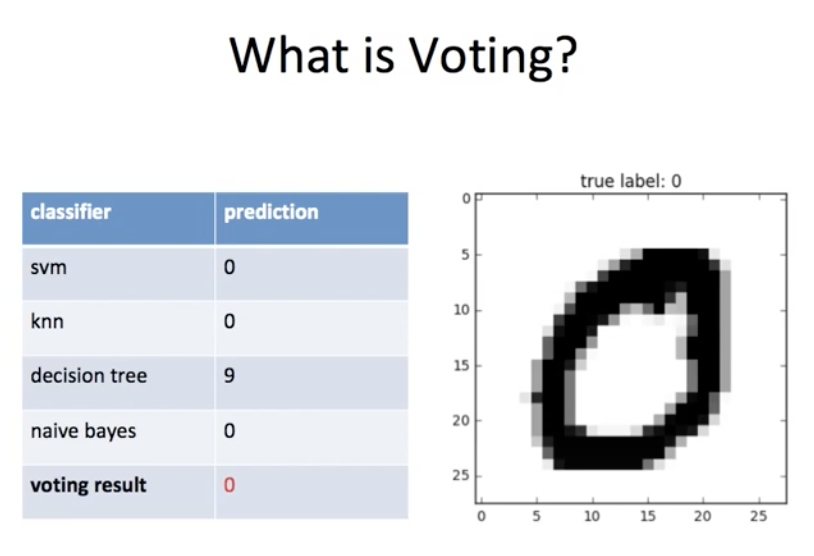

In [ ]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [ ]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8187889581478184


# 2. 빈도수 상위 5,000개의 단어만 사용

In [ ]:
(x2_train, y2_train), (x2_test, y2_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [ ]:
print('훈련 샘플의 수: {}'.format(len(x2_train)))
print('테스트 샘플의 수: {}'.format(len(x2_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [ ]:
# train2 텍스트 데이터로 변환하기
decoded = []
for i in range(len(x2_train)):
    t = ' '.join([index_to_word[index] for index in x2_train[i]])
    decoded.append(t)

x2_train = decoded
print(len(x2_train))

8982


In [ ]:
# test2 텍스트 데이터로 변환하기
decoded = []
for i in range(len(x2_test)):
    t = ' '.join([index_to_word[index] for index in x2_test[i]])
    decoded.append(t)

x2_test = decoded
print(len(x2_test))

2246


### 2.1 벡터화하기


In [ ]:
# DTM2 생성
dtmvector2 = CountVectorizer()
x2_train_dtm = dtmvector2.fit_transform(x2_train)
print("DTM의 크기: ",x2_train_dtm.shape)

# TF-IDF Matrix 2 생성
tfidf_transformer2 = TfidfTransformer()
tfidfv2 = tfidf_transformer2.fit_transform(x2_train_dtm)
print("TF-IDF Matrix의 크기: ",tfidfv2.shape)

DTM의 크기:  (8982, 4867)
TF-IDF Matrix의 크기:  (8982, 4867)


> 단어 총 4857개

### 2.2 나이브 베이즈 분류기

In [ ]:
model2 = MultinomialNB()
model2.fit(tfidfv2, y2_train)

MultinomialNB()

In [ ]:
# test 데이터도 DTM -> tf-idf 행렬로 변환
x2_test_dtm = dtmvector2.transform(x2_test)
tfidfv2_test = tfidf_transformer2.transform(x2_test_dtm)

predicted2 = model2.predict(tfidfv2_test)

# 카테고리 라벨 분류한 정확도
print("정확도:", accuracy_score(y2_test, predicted2))

정확도: 0.6731967943009796


In [ ]:
x2_test[3]

'<sos> <unk> <unk> oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the <unk> hill and north <unk> fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to <unk> principal on its senior secured notes semi annual principal payments on the remaining 40 mln dlrs of notes have been satisfied until december 1988 as a result it said the company said the note agreements were amended to reflect an easing of some financial <unk> and an increase of interest to 13 5 pct from 13 0 pct until december 1990 it said the <unk> exercise price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the <unk> hill field reuter 3'

In [ ]:
y2_test[3]

4

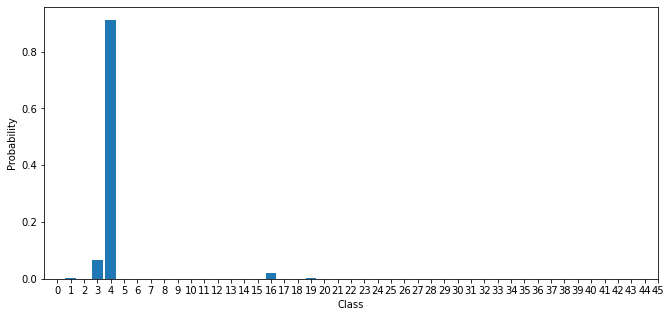

In [ ]:
probability_3_2 = model2.predict_proba(tfidfv2_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(model2.classes_, probability_3_2)
plt.xlim(-1, 21)
plt.xticks(model2.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

- 거의 90프로의 확률로 인덱스 3번 뉴스기사가 4번 클래스라고 맞게 예측했다.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y2_test, model2.predict(tfidfv2_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.66      0.62        99
          17       0.00    

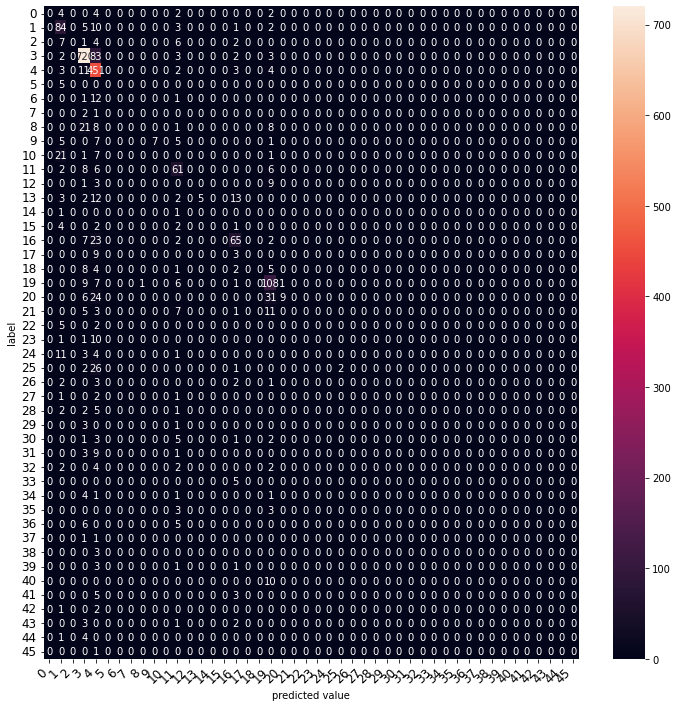

In [ ]:
graph_confusion_matrix(model2, tfidfv2_test, y2_test)

### 2.3 Complement Naive Bayes Classifier(CNB)


In [ ]:
cb2 = ComplementNB()
cb2.fit(tfidfv2, y2_train)

ComplementNB()

In [ ]:
predicted2 = cb2.predict(tfidfv2_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y2_test, predicted2)) #예측값과 실제값 비교

정확도: 0.7707034728406055


-> 나이브 베이즈 분류기보다 약 10프로나 더 높은 성능을 냄

### 2.4 로지스틱 회귀(Logistic Regression)

In [ ]:
lr2 = LogisticRegression(C=10000, penalty='l2')
lr2.fit(tfidfv2, y2_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=10000)

In [ ]:
predicted2 = lr2.predict(tfidfv2_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y2_test, predicted2)) #예측값과 실제값 비교

정확도: 0.8058771148708815


### 2.5 선형 서포트 벡터 머신(Linear Support Vector Machine)

In [ ]:
lsvc2 = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc2.fit(tfidfv2, y2_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [ ]:
predicted2 = lsvc2.predict(tfidfv2_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y2_test, predicted2)) #예측값과 실제값 비교

정확도: 0.7680320569902048


### 2.6 결정 트리(Decision Tree)

In [ ]:
tree2 = DecisionTreeClassifier(max_depth=10, random_state=0)
tree2.fit(tfidfv2, y2_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [ ]:
predicted2 = tree2.predict(tfidfv2_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y2_test, predicted2)) #예측값과 실제값 비교

정확도: 0.6179875333926982


### 2.7 랜덤 포레스트(Random Forest)

In [ ]:
forest2 = RandomForestClassifier(n_estimators=5, random_state=0)
forest2.fit(tfidfv2, y2_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [ ]:
predicted2 = forest2.predict(tfidfv2_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y2_test, predicted2)) #예측값과 실제값 비교

정확도: 0.701246660730187


### 2.8 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [ ]:
grbt2 = GradientBoostingClassifier(random_state=0,verbose=3) 
grbt2.fit(tfidfv2, y2_train)

      Iter       Train Loss   Remaining Time 
         1           1.4697           20.65m
         2     2131099.0239           18.92m
         3 113352934366748750033493137947714414201794552363528671409179356940992512.0000           18.23m
         4 645005367195105573487290209089081189090170195029150070319832395667206596719018218881024.0000           17.82m
         5 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           17.49m
         6 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           17.21m
         7 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           16.94m
         8 44306729953030165998037436352594999562969554969155989028586935092359272354521328055415871220420274508866530693

GradientBoostingClassifier(random_state=0, verbose=3)

In [ ]:
predicted2 = grbt2.predict(tfidfv2_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y2_test, predicted2)) #예측값과 실제값 비교

정확도: 0.767586821015138


### 2.9 보팅(Voting)

In [ ]:
voting_classifier2 = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier2.fit(tfidfv2, y2_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [ ]:
predicted2 = voting_classifier2.predict(tfidfv2_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y2_test, predicted2)) #예측값

정확도: 0.8161175422974176


# 3. 직접 단어 개수를 설정해서 사용
- num_words = 8000


In [ ]:
(x3_train, y3_train), (x3_test, y3_test) = reuters.load_data(num_words=8000, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x3_train)))
print('테스트 샘플의 수: {}'.format(len(x3_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [ ]:
# train 3 텍스트 데이터로 변환하기
decoded = []
for i in range(len(x3_train)):
    t = ' '.join([index_to_word[index] for index in x3_train[i]])
    decoded.append(t)

x3_train = decoded
print(len(x3_train))

8982


In [ ]:
# test3 텍스트 데이터로 변환하기
decoded = []
for i in range(len(x3_test)):
    t = ' '.join([index_to_word[index] for index in x3_test[i]])
    decoded.append(t)

x3_test = decoded
print(len(x3_test))

2246


### 3.1 벡터화하기

In [ ]:
# DTM 생성
dtmvector3 = CountVectorizer()
x3_train_dtm = dtmvector3.fit_transform(x3_train)
print("DTM의 크기: ",x3_train_dtm.shape)

# TF-IDF Matrix 생성
tfidf_transformer3 = TfidfTransformer()
tfidfv3 = tfidf_transformer3.fit_transform(x3_train_dtm)
print("TF-IDF Matrix의 크기: ",tfidfv3.shape)

DTM의 크기:  (8982, 7772)
TF-IDF Matrix의 크기:  (8982, 7772)


### 3.2 나이브 베이즈 분류기

In [ ]:
model3 = MultinomialNB()
model3.fit(tfidfv3, y3_train)

MultinomialNB()

In [ ]:
# test 데이터도 DTM -> tf-idf 행렬로 변환
x3_test_dtm = dtmvector3.transform(x3_test)
tfidfv3_test = tfidf_transformer3.transform(x3_test_dtm)

predicted3 = model3.predict(tfidfv3_test)

# 카테고리 라벨 분류한 정확도
print("정확도:", accuracy_score(y3_test, predicted3))

정확도: 0.6625111308993766


In [ ]:
x3_test[3]

'<sos> <unk> <unk> oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the oak hill and north <unk> fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to <unk> principal on its senior secured notes semi annual principal payments on the remaining 40 mln dlrs of notes have been satisfied until december 1988 as a result it said the company said the note agreements were amended to reflect an easing of some financial <unk> and an increase of interest to 13 5 pct from 13 0 pct until december 1990 it said the <unk> exercise price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the oak hill field reuter 3'

In [ ]:
y3_test[3]

4

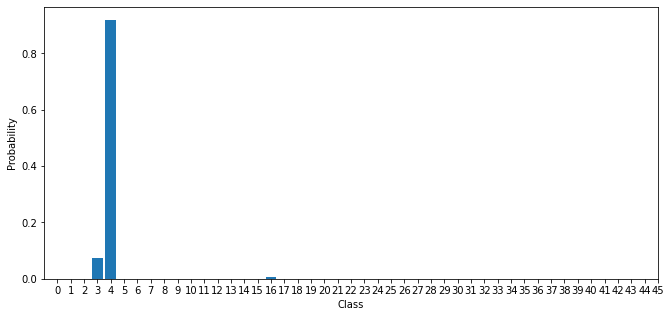

In [ ]:
probability_3_3 = model3.predict_proba(tfidfv3_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(model3.classes_, probability_3_3)
plt.xlim(-1, 21)
plt.xticks(model3.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

- 약 90프로 확률로 4번 클래스라고 맞게 예측함

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y3_test, model3.predict(tfidfv3_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.59      0.75      0.66       105
           2       0.00      0.00      0.00        20
           3       0.82      0.90      0.86       813
           4       0.54      0.96      0.69       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.16      0.28        25
          10       0.00      0.00      0.00        30
          11       0.58      0.67      0.63        83
          12       0.00      0.00      0.00        13
          13       1.00      0.05      0.10        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.66      0.59      0.62        99
          17       0.00    

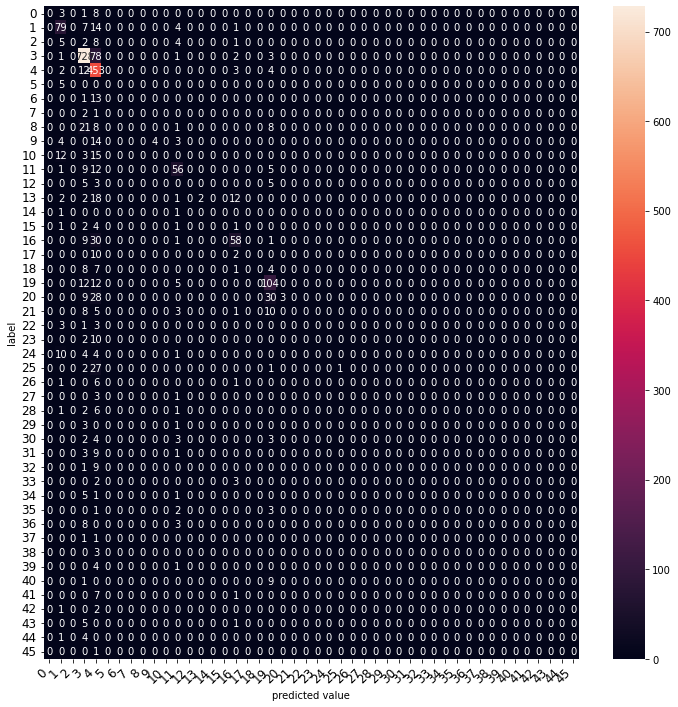

In [ ]:
# confusion matrix 시각화
graph_confusion_matrix(model3, tfidfv3_test, y3_test)

### 3.3 Complement Naive Bayes Classifier(CNB)

In [ ]:
cb3 = ComplementNB()
cb3.fit(tfidfv3, y3_train)

ComplementNB()

In [ ]:
predicted3 = cb3.predict(tfidfv3_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y3_test, predicted3)) #예측값과 실제값 비교

정확도: 0.7707034728406055


### 3.4 로지스틱 회귀(Logistic Regression)

In [ ]:
lr3 = LogisticRegression(C=10000, penalty='l2')
lr3.fit(tfidfv3, y3_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=10000)

In [ ]:
predicted3 = lr3.predict(tfidfv3_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y3_test, predicted3)) #예측값과 실제값 비교

정확도: 0.8098842386464826


### 3.5 선형 서포트 벡터 머신(Linear Support Vector Machine)

In [ ]:
lsvc3 = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc3.fit(tfidfv3, y3_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [ ]:
predicted3 = lsvc3.predict(tfidfv3_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y3_test, predicted3)) #예측

정확도: 0.7711487088156723


### 3.6 결정 트리(Decision Tree)

In [ ]:
tree3 = DecisionTreeClassifier(max_depth=10, random_state=0)
tree3.fit(tfidfv3, y3_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [ ]:
predicted3 = tree3.predict(tfidfv3_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y3_test, predicted3)) #예측값과 실제값 비교

정확도: 0.6206589492430988


### 3.7 랜덤 포레스트(Random Forest)


In [ ]:
forest3 = RandomForestClassifier(n_estimators=5, random_state=0)
forest3.fit(tfidfv3, y3_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [ ]:
predicted3 = forest3.predict(tfidfv3_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y3_test, predicted3)) #예측값과 실제값 비교

정확도: 0.6669634906500446


### 3.8 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [ ]:
grbt3 = GradientBoostingClassifier(random_state=0,verbose=3) 
grbt3.fit(tfidfv3, y3_train)

      Iter       Train Loss   Remaining Time 
         1           1.4623           24.63m
         2     8660007.6663           21.28m
         3   875988650.4729           20.06m
         4 487291772348199360.0000           19.35m
         5 1494368684701080172103932709351465585696707706880.0000           18.88m
         6 76262468764199180251727454826972312784663848937957200250741567905298202274824192.0000           18.51m
         7 76262468764199180251727454826972312784663848937957200250741567905298202274824192.0000           18.20m
         8 76262468764199180251727454826972312784663848937957200250741567905298202274824192.0000           17.91m
         9 76262468764199180251727454826972312784663848937957200250741567905298202274824192.0000           17.66m
        10 76262468764199180251727454826972312784663848937957200250741567905298202274824192.0000           17.51m
        11 76262468764199180251727454826972312784663848937957200250741567905298202274824192.0000           17.29m


GradientBoostingClassifier(random_state=0, verbose=3)

In [ ]:
predicted3 = grbt3.predict(tfidfv3_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y3_test, predicted3)) #예측값과 실제값 비교

정확도: 0.7644701691896705


### 3.9 보팅(Voting)

In [ ]:
voting_classifier3 = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier3.fit(tfidfv3, y3_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [ ]:
predicted3 = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y3_test, predicted3)) #예측값과 실

정확도: 0.8187889581478184


# 회고
1. 모든 단어 사용했을 때 정확도
> - 나이브 베이즈 분류기 : 0.5997328584149599
> - CNB : 0.7649154051647373
> - 로지스틱 회귀 : 0.813446126447017
> - 선형 SVM : 0.7729296527159395
> - 결정 트리 : 0.6211041852181657
> - 랜덤 포레스트 : 0.6544968833481746
> - 그래디언트 부스팅 트리 : 0.7702582368655387
> - 보팅 : 0.8187889581478184

2. 빈도수 상위 5,000개의 단어만 사용
> - 나이브 베이즈 분류기 : 0.6731967943009796
> - CNB : 0.7707034728406055
> - 로지스틱 회귀 : 0.8058771148708815
> - 선형 SVM : 0.7680320569902048
> - 결정 트리 : 0.6179875333926982
> - 랜덤 포레스트 : 0.701246660730187
> - 그래디언트 부스팅 트리 : 0.767586821015138
> - 보팅 : 0.8161175422974176

3. 빈도수 상위 8,000개의 단어만 사용
> - 나이브 베이즈 분류기 : 정확도: 0.6625111308993766
> - CNB : 0.7707034728406055
> - 로지스틱 회귀 : 0.8098842386464826
> - 선형 SVM : 0.7711487088156723
> - 결정 트리 : 0.6206589492430988
> - 랜덤 포레스트 : 0.6669634906500446
> - 그래디언트 부스팅 트리 : 0.7644701691896705
> - 보팅 : 0.8187889581478184

- 함수로 만들고 num_words 바꿔가면서 하면됐는데 괜히 더 귀찮은 방법으로 했다
- 모든 단어를 썼을때나 빈도수 상위 8000개 썼을 때나 보팅 모델쓰면 정확도가 똑같이 나온다.
- num_words를 적당히 잡는게 연산 속도도 고려한다고 생각하면 중요한것 같다.